## Notebook Vae kaggle

In [ ]:
!pip install -r ../requirements.txt

In [1]:
from torch import nn, optim
import torch

import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from facenet_pytorch import InceptionResnetV1
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image
import matplotlib.pyplot as plt
import os

from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

import lpips
import time
import kagglehub

/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import utils
import dataloader

In [36]:

from sklearn.datasets import fetch_olivetti_faces
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images  # Images de taille (64, 64)

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /home/e20210000275/scikit_learn_data


In [123]:
# Download latest version
path = kagglehub.dataset_download("ashwingupta3012/human-faces")

print("Path to dataset files:", path)

100%|██████████| 1.82G/1.82G [01:12<00:00, 26.8MB/s]

Extracting files...


Path to dataset files: /home/e20210000275/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1


In [34]:
print("Cuda compatible : ", torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

Cuda compatible :  True


In [156]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
import random

# Définir les transformations pour redimensionner les images à 64x64
transform = Compose([
    Resize((64, 64)),  # Redimensionner les images à 64x64
    ToTensor(),        # Convertir en tenseur PyTorch
    Normalize((0.5,), (0.5,))  # Normaliser les pixels entre -1 et 1
])

# Charger le dataset complet
dataset_path = "/home/e20210000275/.cache/kagglehub/datasets/ashwingupta3012/human-faces/versions/1"
human_faces_dataset = ImageFolder(root=dataset_path, transform=transform)

# Réduire à 5% du dataset
dataset_size = len(human_faces_dataset)
subset_size = int(0.07 * dataset_size)  # 5% des données
indices = random.sample(range(dataset_size), subset_size)  # Sélectionner des indices aléatoires
subset_dataset = Subset(human_faces_dataset, indices)

# Diviser le sous-dataset en train/test
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(subset_dataset, [train_size, test_size])

# Créer les DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Nombre d'images dans le sous-dataset : {len(subset_dataset)}")
print(f"Nombre d'images dans le train set : {len(train_dataset)}")
print(f"Nombre d'images dans le test set : {len(test_dataset)}")

Nombre d'images dans le sous-dataset : 505
Nombre d'images dans le train set : 404
Nombre d'images dans le test set : 101


In [157]:
class ETA:
    t = []
    @staticmethod
    def fmt(s):
        s=int(s);m,s=divmod(s,60);h,m=divmod(m,60)
        return f"{h}h {m}m {s}s" if h else f"{m}m {s}s" if m else f"{s}s"

    def __init__(self,total,win=50):
        self.total=total;self.win=win;self.step=0

    def update(self):
        ETA.t.append(time.time())
        ETA.t=ETA.t[-self.win:]
        self.step+=1

    def eta(self):
        if self.step<2:return 0
        d=[ETA.t[i]-ETA.t[i-1] for i in range(1,len(ETA.t))]
        return (self.total-self.step)*(sum(d)/len(d))
    def print(self):
        print(ETA.fmt(self.eta()))

In [158]:
EMBEDDING_SIZE = 128

class VAE(nn.Module):
    def __init__(self, embedding=128):
        super().__init__()
        self.embedding = embedding
        self.max_feature = 16
        self.img_size = 64

        # Définir l'encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Calculer la taille aplatie après l'encodeur
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, self.img_size, self.img_size)
            dummy_output = self.encoder(dummy_input)
            self.flattened_size = dummy_output.numel()

        # Définir les couches restantes
        self.fc_decode = nn.Linear(self.embedding, self.flattened_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

        self.fc_mu = nn.Linear(self.flattened_size, self.embedding)
        self.fc_logvar = nn.Linear(self.flattened_size, self.embedding)

    def encode(self, x):
        encoded = self.encoder(x)
        #print(f"Taille après encodeur : {encoded.shape}")
        f = torch.flatten(encoded,1)
        mean = self.fc_mu(f)
        logvar = self.fc_logvar(f)
        return mean, logvar

    def reparametrize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mean

    def forward(self, x):
        mean, logvar = self.encode(x)
        #print(f"Mean shape: {mean.shape}, Logvar shape: {logvar.shape}")  # Vérifiez les dimensions

        z = self.reparametrize(mean, logvar)
        h = self.fc_decode(z)
        h = h.view(-1, self.max_feature, self.img_size // 4, self.img_size // 4)  # Ajustez ici si nécessaire
        res = self.decoder(h)
        return z, res, mean, logvar
    
    def random(self):

        z = torch.randn((1, self.embedding), device=next(self.parameters()).device)

        h = self.fc_decode(z)

        h = h.view(-1, self.max_feature, self.img_size, self.img_size)

        res = self.decoder(h)
        return z, res

In [159]:
autoencoder = VAE().to(device)

final_classifier_loss = [0.0,0.0]
losses = []

L1loss = nn.L1Loss()
lpipsLoss = lpips.LPIPS(net='alex').to(device)
lpips_factor = 0.00

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

model_parameters = filter(lambda p: p.requires_grad, autoencoder.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"VAE has {params} parameters")

beta = 1.0

def elbo_loss(recon, x, mean, logvar):
    #lpi_loss = lpipsLoss(recon, x).mean() * lpips_factor 
    recon_loss = (F.l1_loss(recon, x, reduction='sum') )/x.size(0) 
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + beta * kl_loss , recon_loss, beta * kl_loss

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
VAE has 1581099 parameters


In [160]:
epochs = 125
eta = ETA(epochs)

for epoch in range(epochs):
    eta.update()
    eta.print()
    total_loss = 0.0
    autoencoder.train()

    for images, labels in train_loader:
        # Vérifiez que les images sont des tenseurs PyTorch
        if isinstance(images, np.ndarray):
            images = torch.tensor(images, dtype=torch.float32)

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        z, recon, mean, logvar = autoencoder(images)

        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    autoencoder.eval()
    total_eval_loss = 0.0
    for images, labels in test_loader:
        if isinstance(images, np.ndarray):
            images = torch.tensor(images, dtype=torch.float32)

        images = images.to(device)
        labels = labels.to(device)

        z, recon, mean, logvar = autoencoder(images)
        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)

        total_eval_loss += loss.item()

    scheduler.step()

    total_loss = total_loss / len(train_loader)
    total_eval_loss = total_eval_loss / len(test_loader)
    print(f"Epoch {epoch+1}, training loss: {total_loss:.4f}, test loss: {total_eval_loss:.4f}")

    losses.append((total_loss, total_eval_loss))

    final_classifier_loss[0] = total_loss
    final_classifier_loss[1] = total_eval_loss

    if (epoch + 1) % 50 == 0:
        # torch.save(autoencoder.state_dict(), f"models/autoencoder_epoch_{epoch+1}.pth")
        pass

0s
Epoch 1, training loss: 6348.0782, test loss: 6304.5850
33m 49s
Epoch 2, training loss: 6159.5082, test loss: 6056.1047
24m 23s
Epoch 3, training loss: 5740.1860, test loss: 5490.4233
21m 2s
Epoch 4, training loss: 5339.4717, test loss: 5004.0701
19m 23s
Epoch 5, training loss: 4900.5491, test loss: 5038.3804
18m 20s
Epoch 6, training loss: 4644.3765, test loss: 4714.5347
17m 26s
Epoch 7, training loss: 4505.0277, test loss: 4588.4683
16m 50s
Epoch 8, training loss: 4398.4054, test loss: 4339.3843
16m 21s
Epoch 9, training loss: 4244.9484, test loss: 4190.9497
15m 59s
Epoch 10, training loss: 4219.1301, test loss: 4178.3000
15m 40s
Epoch 11, training loss: 4082.6623, test loss: 3985.8014
15m 23s
Epoch 12, training loss: 3772.7510, test loss: 3799.8026
15m 7s
Epoch 13, training loss: 3486.0777, test loss: 3454.4711
14m 54s
Epoch 14, training loss: 3246.1219, test loss: 3430.0493
14m 43s
Epoch 15, training loss: 3181.5288, test loss: 3276.1150
14m 32s
Epoch 16, training loss: 3000.781

In [161]:
torch.save(autoencoder.state_dict(), "models/autoencoder_on_base_dataset.pth")

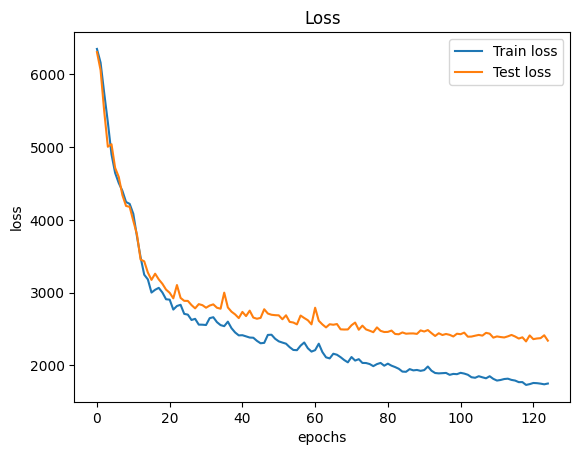

In [162]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

/tmp/ipykernel_22481/3097923996.py:24: RuntimeWarning: Mean of empty slice.
  avg_emb = emb_np[idx].mean(axis=0)
/home/e20210000275/M2/Projet Image/Face-Swap-M2/venv/lib/python3.9/site-packages/numpy/_core/_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


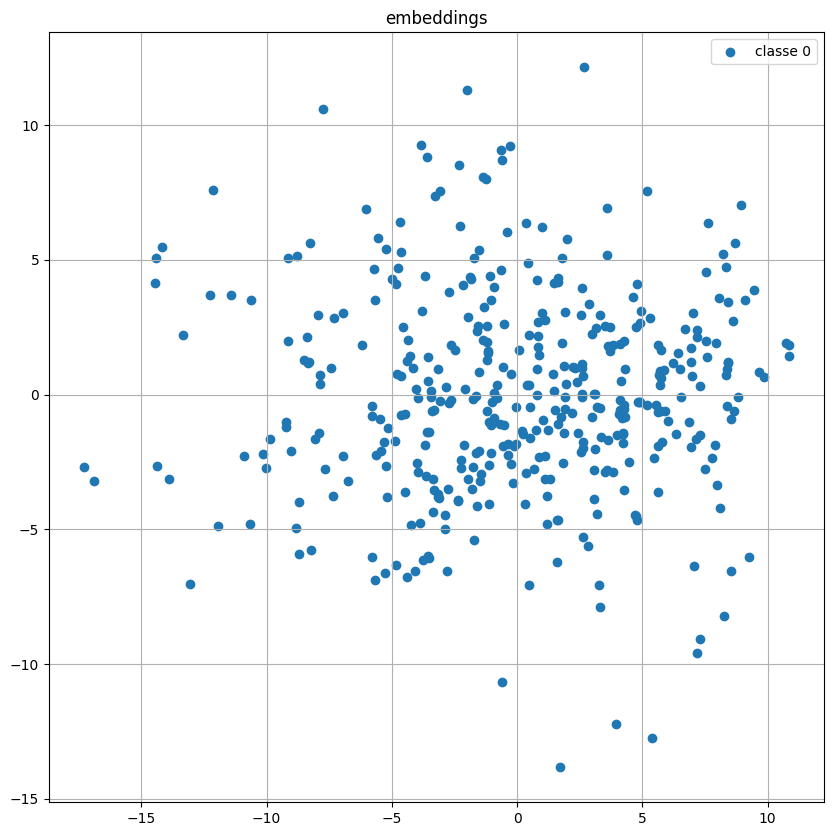

In [163]:
autoencoder.eval()
embeddings = []
avg_embeddings = []
with torch.no_grad():
    for images, labels in train_loader:
        #print(labels)
        #images = torch.flatten(images, 1)

        images = images.to(device)
        labels = labels.to(device)

        emb, output,_,_ = autoencoder(images)

        for i in range(emb.size(0)):
            embeddings.append([emb[i].cpu().tolist(), labels[i].cpu().item()])

    emb_np = np.array([item[0] for item in embeddings])
    lab_np = np.array([item[1] for item in embeddings])



    for cls in range(nb_classes):
        idx = np.where(lab_np == cls)[0]
        avg_emb = emb_np[idx].mean(axis=0)

        avg_embeddings.append(avg_emb)

        #print(f"classe {cls}: avg embedding = {avg_emb.tolist()}")

def plot_embeddings():
    embeddings_np = np.array([e[0] for e in embeddings])
    labels_np = np.array([e[1] for e in embeddings])

    pca = PCA(n_components=2) #reduction en 2D
    reduced_embeddings = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(10, 10))
    for label in np.unique(labels_np):
        idx = labels_np == label
        plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"classe {label}")

    plt.title("embeddings")
    plt.legend()
    plt.grid(True)
    plt.show()



plot_embeddings()

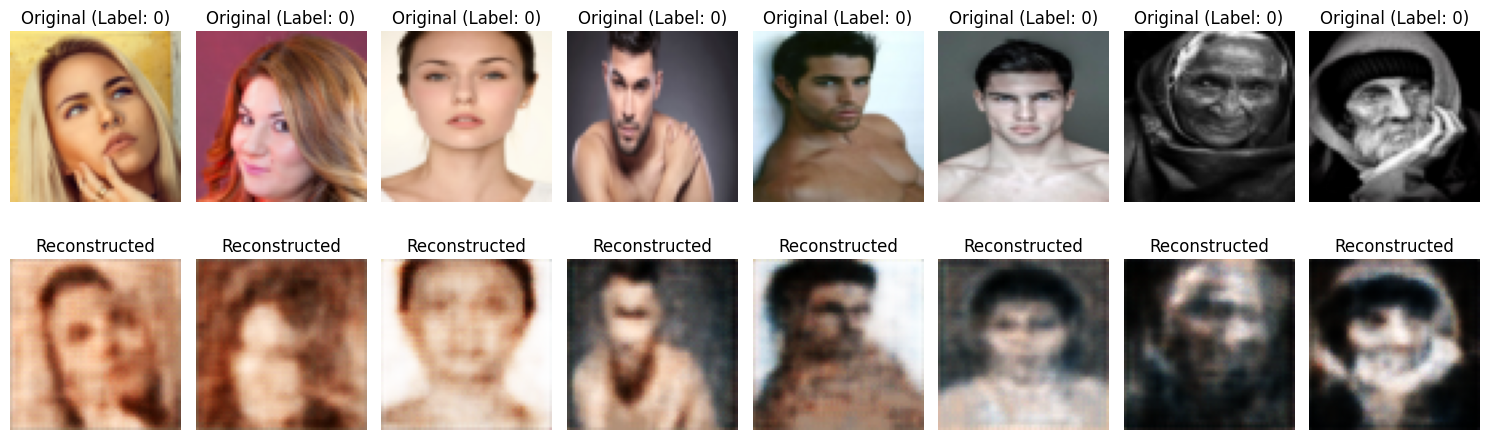

In [164]:
autoencoder.eval()

images, labels = next(iter(train_loader))
images = images.to(device)

with torch.no_grad():

    _,reconstructed_images, _,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

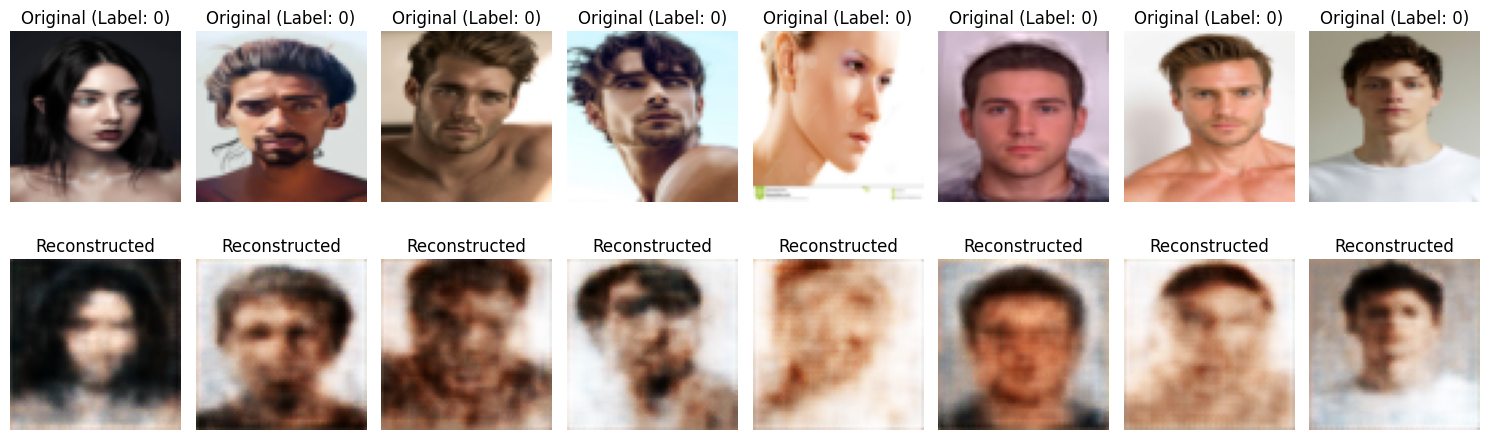

In [165]:
autoencoder.eval()

images, labels = next(iter(test_loader))
images = images.to(device)

with torch.no_grad():
    _,reconstructed_images,_,_ = autoencoder(images)


n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = img.min(), img.max()
    img_disp = (img - mi) / (ma - mi) if ma - mi > 1e-6 else img
    axs[0, i].imshow(img_disp)
    axs[0, i].set_title(f"Original (Label: {labels[i].item()})")
    axs[0, i].axis("off")

    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    mi, ma = recon_img.min(), recon_img.max()
    recon_disp = (recon_img - mi) / (ma - mi) if ma - mi > 1e-6 else recon_img
    axs[1, i].imshow(recon_disp)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

# fine tunig

Charger les images personelles :

In [166]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, Grayscale
from torch.utils.data import DataLoader

# Définir les transformations pour vos images personnelles
personal_transform = Compose([
    Resize((64, 64)),  # Assurez-vous que la taille correspond à celle utilisée dans le modèle
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Charger les données personnelles
personal_dataset = ImageFolder(root="../data/Face-Swap-M2-Dataset/dataset/cropped/", transform=personal_transform)

# Diviser en train/test
train_size = int(0.8 * len(personal_dataset))
test_size = len(personal_dataset) - train_size
personal_train_dataset, personal_test_dataset = torch.utils.data.random_split(personal_dataset, [train_size, test_size])

# Créer les DataLoaders
personal_train_loader = DataLoader(personal_train_dataset, batch_size=16, shuffle=True)
personal_test_loader = DataLoader(personal_test_dataset, batch_size=16, shuffle=False)

print(f"Nombre d'images dans le dataset personnel : {len(personal_dataset)}")
print(f"Nombre de classes (personnes) : {len(personal_dataset.classes)}")

Nombre d'images dans le dataset personnel : 73
Nombre de classes (personnes) : 10


In [167]:
# Charger les poids du modèle pré-entraîné
autoencoder.load_state_dict(torch.load("models/autoencoder_on_base_dataset.pth"))
autoencoder.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_decode): Linear(in_features=128, out_features=4096, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(8, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Tanh()
  )
  (fc_mu): Linear(in_features=4096, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=4096, out_features=128, bias=True)
)

boucle d'entraînement pour le fine-tuning :

In [168]:
autoencoder.train()

# Définir un nouvel optimiseur avec un taux d'apprentissage plus faible
fine_tune_optimizer = optim.Adam(autoencoder.parameters(), lr=0.0001)

# Fine-tuning sur les données personnelles
fine_tune_epochs = 300
for epoch in range(fine_tune_epochs):
    total_loss = 0.0
    for images, _ in personal_train_loader:  # Les labels ne sont pas nécessaires pour un VAE
        images = images.to(device)

        fine_tune_optimizer.zero_grad()

        # Passer les images dans le modèle
        z, recon, mean, logvar = autoencoder(images)

        # Calculer la perte
        loss, recon_loss, kl_loss = elbo_loss(recon, images, mean, logvar)
        loss.backward()
        fine_tune_optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{fine_tune_epochs}, Loss: {total_loss / len(personal_train_loader):.4f}")

Epoch 1/300, Loss: 2556.9352
Epoch 2/300, Loss: 2226.2986
Epoch 3/300, Loss: 2114.1523
Epoch 4/300, Loss: 2113.7403
Epoch 5/300, Loss: 1997.7783
Epoch 6/300, Loss: 1933.7933
Epoch 7/300, Loss: 1890.8568
Epoch 8/300, Loss: 1857.0995
Epoch 9/300, Loss: 1833.0536
Epoch 10/300, Loss: 1791.9126
Epoch 11/300, Loss: 1777.7191
Epoch 12/300, Loss: 1773.6099
Epoch 13/300, Loss: 1717.2675
Epoch 14/300, Loss: 1727.8669
Epoch 15/300, Loss: 1695.3267
Epoch 16/300, Loss: 1661.9853
Epoch 17/300, Loss: 1637.7765
Epoch 18/300, Loss: 1632.5121
Epoch 19/300, Loss: 1607.5686
Epoch 20/300, Loss: 1613.5918
Epoch 21/300, Loss: 1590.0501
Epoch 22/300, Loss: 1578.5781
Epoch 23/300, Loss: 1593.2011
Epoch 24/300, Loss: 1543.8764
Epoch 25/300, Loss: 1536.4595
Epoch 26/300, Loss: 1573.7988
Epoch 27/300, Loss: 1533.0755
Epoch 28/300, Loss: 1521.8396
Epoch 29/300, Loss: 1525.9000
Epoch 30/300, Loss: 1552.2025
Epoch 31/300, Loss: 1496.2232
Epoch 32/300, Loss: 1490.3627
Epoch 33/300, Loss: 1477.9840
Epoch 34/300, Loss:

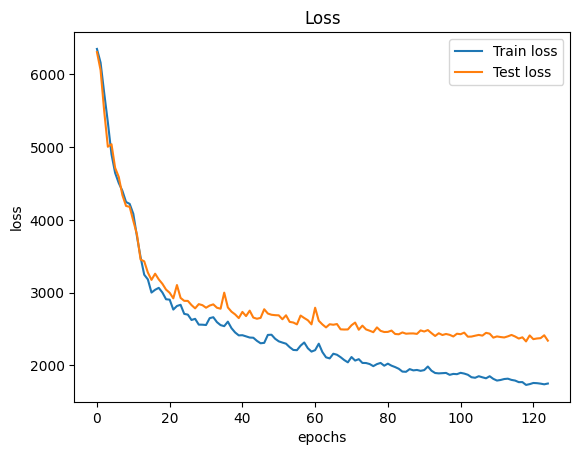

In [169]:
plt.figure()
plt.plot(losses, label="Loss")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Train loss", "Test loss"])
plt.show()

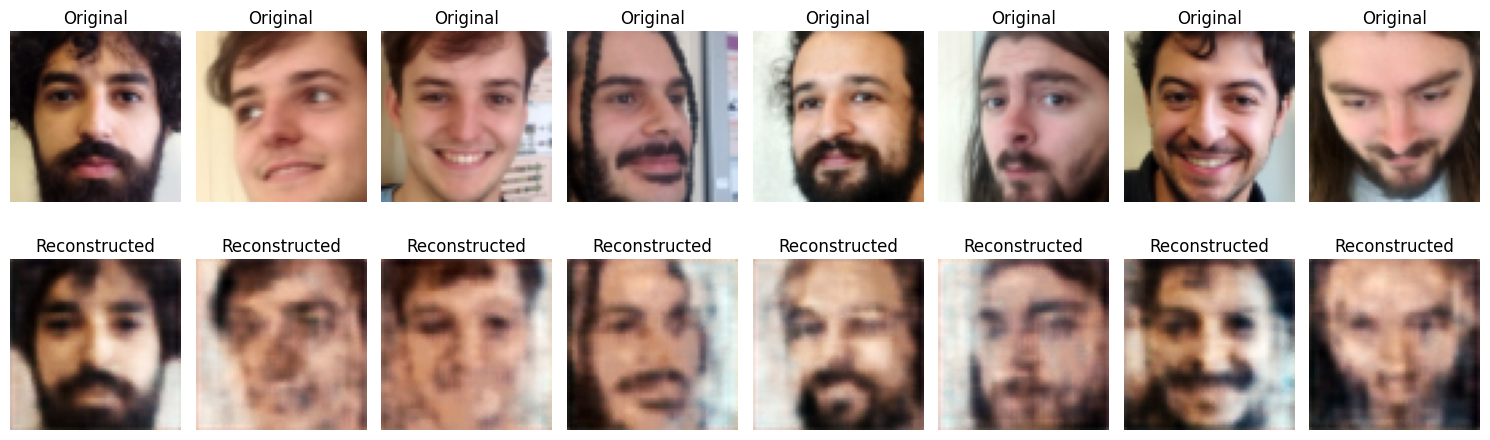

In [170]:
autoencoder.eval()

images, _ = next(iter(personal_test_loader))
images = images.to(device)

with torch.no_grad():
    _, reconstructed_images, _, _ = autoencoder(images)

n = min(8, images.size(0))
fig, axs = plt.subplots(2, n, figsize=(15, 5))

for i in range(n):
    # Image originale
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    axs[0, i].imshow(img)
    axs[0, i].set_title("Original")
    axs[0, i].axis("off")

    # Image reconstruite
    recon_img = reconstructed_images[i].permute(1, 2, 0).cpu().numpy()
    recon_img = (recon_img - recon_img.min()) / (recon_img.max() - recon_img.min())
    axs[1, i].imshow(recon_img)
    axs[1, i].set_title("Reconstructed")
    axs[1, i].axis("off")

plt.tight_layout()
plt.show()

torch.save(autoencoder.state_dict(), "models/fine_tuned_autoencoder.pth")